#### Goal: 
To identify the factors that influence the prices of Airbnb listings in the Boston area

#### Business Questions:

(1). What are the busiest times of the year to visit Boston?

(2). Who are the hosts with the most number of AirBnb listings?

(3). Which are the most popular neighbourhoods based on average number of reviews?

(4). Which neighbourhoods are considered the most expensive in Boston?

(5). What are the key drivers of prices of AirBnb listings?

##### imports

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.regression.linear_model import OLS
import re
import os

pd.set_option('display.max_columns',100)

%matplotlib inline

#### Helper functions

In [196]:
def clean_price(df,col):
    '''Cleans the price field by removing the $ sign and , from the field and casting to numeric
    Inputs:
    df: dataframe containing the price column that needs cleaning
    
    Output:
    Returns a numeric field for price with the special characters removed'''
    
    return pd.to_numeric(df[col].str.replace('$','').str.replace(',',''))

def word_count(col):
    """This function counts the number of words in a sentence and returns the count
    Input:
    col: columns containing phrase(s) for which you want to count words
    
    Output:
    Returns the count of the number of words in the sentence"""
    return listings[col].str.count(" ") + 1

def binarize(col):
    """Converts binary values containing t and f values to 1 and 0 respectively
       input:
       col: column containing values t or f
       
       Output:
       Series containing values 1 and 0 respectively"""
    return int(col == 't')

def clean_percentages(col):
    '''This function removes % signs from strings and converts them to numeric types
    
    input:
    col: name of the column containing percentage sign
    
    output:
    Returns numeric field'''
    return pd.to_numeric(listings[col].str.replace('%',''), errors = 'coerce')

def categorise(col: 'categorical column'):
    """Reduces cardinality of categorical variables by grouping up every category that has less than a 
       5% representation to a bucket - other
       
       input:
       col: categorical column
       """
    #number of unique values
    n_unique = listings[col].nunique()
    
    #perc representation
    temp = listings[col].value_counts(normalize = True, dropna = False)
    
    for i in range(len(temp.values)):
        if temp.values[i] < 0.05 and n_unique > 5:
            listings.loc[listings[col]==temp.index[i], col] = 'other'  
            
    listings[col].fillna('other',inplace = True)
    
def top_bottom_coding(col):
    """Perform top and bottom coding of extreme outliers
    
    input:
    col: numeric columns with suspected outliers
    
    output:
    returns the field with values capped at the upper bound"""
    q1 = listings[col].quantile(q = 0.25)
    q3 = listings[col].quantile(q = 0.75)
    upper_bound = q3 + (3*(q3 - q1))
    lower_bound = q1 - (3*(q3-q1))
    
    listings.loc[listings[col] > upper_bound, col] = upper_bound
    listings.loc[listings[col] < lower_bound, col] = lower_bound
    
def label_encode(col: 'object type'):
    '''Label encodes categorical fields and returns the same field with the encodings'''
    # Label encoder instance
    lab_enc = LabelEncoder()

    # fit label encoder
    lab_enc.fit(listings2[col])

    # transform
    listings2[col] = lab_enc.transform(listings2[col])

#### import data sets

In [197]:
pathname = '/Users/paulndikumfru/desktop/data/project1-airbnb'

# read in data sets
calendar = pd.read_csv(os.path.join(pathname, 'calendar.csv'))
listings = pd.read_csv(os.path.join(pathname, 'listings.csv'))

In [198]:
for data in [calendar, listings]:
    display(data.head())

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United Sta

### Data Preparation
I'll start off by selecting a baseline list of features which will be used throughout the analysis

In [199]:
# limiting our list of columns in the listings table to the below
cols = ['host_id',
'host_name',
'host_since',
'host_response_time',
'host_response_rate',
'host_acceptance_rate',
'neighbourhood_cleansed',
'host_verifications',
'host_has_profile_pic',
'host_identity_verified',
'is_location_exact',
'property_type',
'room_type',
'accommodates',
'bathrooms',
'bedrooms',
'beds',
'bed_type',
'security_deposit',
'cleaning_fee',
'guests_included',
'extra_people',
'maximum_nights',
#'calendar_updated',
'availability_30',
'availability_60',
'availability_90',
'availability_365',
'number_of_reviews',
'last_review',
'review_scores_rating',
'review_scores_accuracy',
'review_scores_checkin',
'review_scores_communication',
'review_scores_location',
'review_scores_value',
'instant_bookable',
'cancellation_policy',
'require_guest_profile_picture',
'require_guest_phone_verification',
'calculated_host_listings_count',
'reviews_per_month',
'description',
'access',
'amenities',
'house_rules',
'host_about',
'price']

In [200]:
# create list containing all columns we want to drop from listings table
cols_to_drop = [field for field in listings.columns if field not in cols]

print("We'll be dropping {} columns from listings".format(len(cols_to_drop)))

# drop columns 
listings.drop(columns = cols_to_drop, inplace = True)
print("Columns in listings match expectation: {}".format(len(listings.columns)==len(cols)))

We'll be dropping 48 columns from listings
Columns in listings match expectation: True


#### Perform a quick EDA

In [201]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   description                       3585 non-null   object 
 1   access                            2096 non-null   object 
 2   house_rules                       2393 non-null   object 
 3   host_id                           3585 non-null   int64  
 4   host_name                         3585 non-null   object 
 5   host_since                        3585 non-null   object 
 6   host_about                        2276 non-null   object 
 7   host_response_time                3114 non-null   object 
 8   host_response_rate                3114 non-null   object 
 9   host_acceptance_rate              3114 non-null   object 
 10  host_verifications                3585 non-null   object 
 11  host_has_profile_pic              3585 non-null   object 
 12  host_i

In [202]:
listings.describe(include = 'object')

,description,access,house_rules,host_name,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,bed_type,amenities,price,security_deposit,cleaning_fee,extra_people,last_review,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,3585,2096,2393,3585,3585,2276,3114,3114,3114,3585,3585,3585,3585,3585,3582,3585,3585,3585,3585,1342,2478,3585,2829,3585,3585,3585,3585
unique,3423,1762,1928,1334,1281,1240,4,52,72,83,2,2,25,2,13,3,5,3092,324,54,79,51,404,2,4,2,2
top,Studio offers the luxury of home furnishings w...,"You have access to the entire apartment, and a...",House Rules 1. Check-in is 4 pm local time. If...,Kara,2015-03-30,ABOUT US:\r\n\r\nSeamlessTransition is a full-...,within an hour,100%,100%,"['email', 'phone', 'reviews', 'jumio']",t,t,Jamaica Plain,t,Apartment,Entire home/apt,Real Bed,{},$150.00,$100.00,$100.00,$0.00,2016-09-05,f,strict,f,f
freq,7,48,44,138,137,79,1384,2072,1210,930,3577,2603,343,3080,2612,2127,3453,32,144,299,353,2211,118,2991,1582,3518,3348


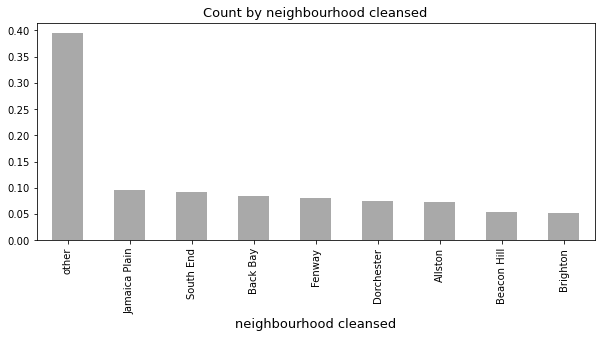

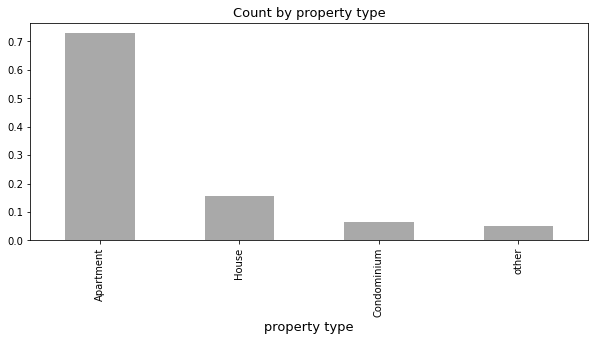

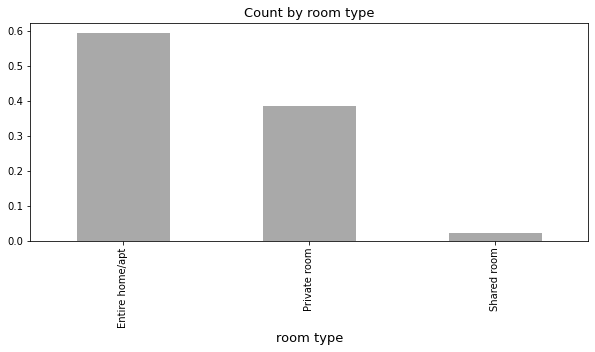

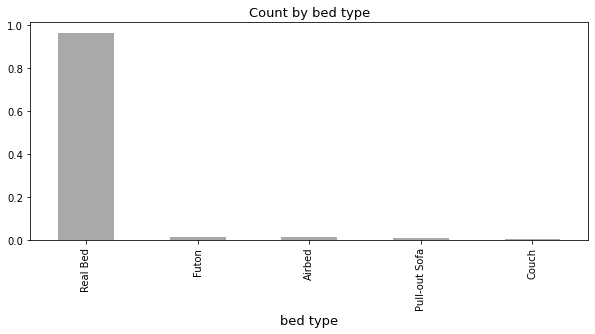

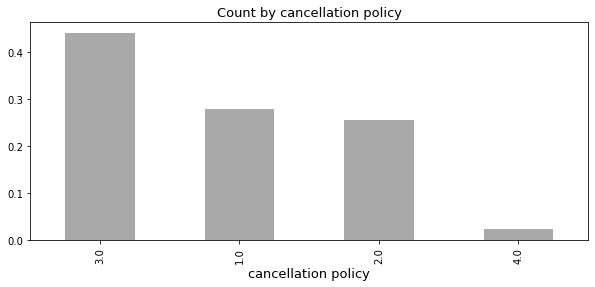

In [262]:
for col in ('neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy'):  #'calendar_updated'
    col_cleansed = col.replace('_',' ')
    listings[col].value_counts(normalize = True, dropna = False).plot(kind = 'bar', figsize = (10,4), color = 'darkgrey')
    plt.title('Count by {}'.format(col_cleansed), fontsize = 13)
    plt.xlabel(col_cleansed, fontsize = 13)
    plt.show()

#### Feature Engineering/Data Manipulation

In [206]:
# count the number of words in the description fields
for col in ['description','access','amenities','house_rules','host_about','host_verifications']:
    listings[col + '_count'] = word_count(col)

# t_f_columns are binary colummns having values t or f - we'll convert them to 1 and 0 respectively
t_f_columns =  ('host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable',
                'require_guest_profile_picture','require_guest_phone_verification')

for col in t_f_columns:
    listings[col] = listings[col].apply(binarize)
    
#cluster the categories of categorical variables
for col in ('neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy'):
    categorise(col)
  

#ORDINAL VARIABLES
cancellation_policy_mapper = {'super_strict_30':4,'strict':3, 'moderate':2,'flexible':1}
resp_time_mapper = {'within an hour':4, 'within a few hours':3,'within a day': 2, 'a few days or more': 1}

listings['cancellation_policy'] = listings.cancellation_policy.map(cancellation_policy_mapper)
listings['host_response_time'] = listings['host_response_time'].map(resp_time_mapper)
    
# clean columns with percentage signs by removing them, casting to numeric, and dividing by 100
for col in ('host_response_rate','host_acceptance_rate'):
    listings[col] = (clean_percentages(col)).div(100)
    
# money fields are those numeric fields that contain $ and , making them strings - let's clean them
money_fields = ('price','security_deposit','cleaning_fee','extra_people')

for col in money_fields:
    listings[col] = clean_price(listings, col)
    
# assign right types to date fields 
for col in ['host_since','last_review']:
    listings[col] = pd.to_datetime(listings[col], errors = 'coerce')
    
# derive customer tenure as at end of 2017
listings['customer_tenure'] = (pd.to_datetime('2017-12-31') - listings['host_since']).dt.days.div(365)

# derive days since last review
listings['day_since_last_rev'] = (pd.to_datetime('2017-12-31') - listings['last_review']).dt.days

# create an ordinal variable out of host_response_time
listings.host_response_time.map({'within an hour':0,'within a few hours': 2,'within a day':3,'a few days or more':4})

# drop columns
listings.drop(labels = ['description','access','amenities','house_rules','host_about',
                        'host_verifications','host_since','last_review'], axis = 1, inplace = True)

Text(0, 0.5, 'Percentage')

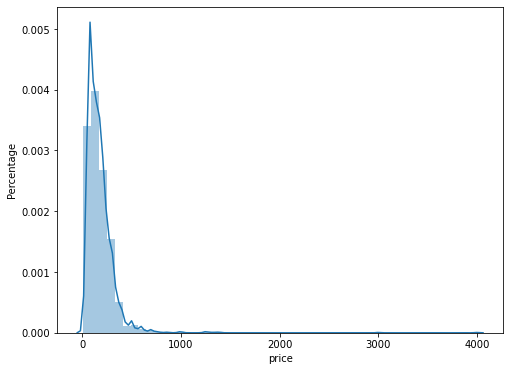

In [207]:
plt.figure(figsize = (8,6))
sns.distplot(listings['price']);
plt.ylabel('Percentage', fontsize = 10)

In [208]:
print(listings.price.describe())

print('variance',listings.price.var())

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64
variance 22002.180877042152


In [209]:
print("Airbnb property's that cost less than $30")
listings.loc[listings.price <= 30, 'property_type'].value_counts()

Airbnb property's that cost less than $30


Apartment      18
House           6
other           1
Condominium     1
Name: property_type, dtype: int64

- The average price of an AirBnB listing is 173
- The variance is 22002. Price fluctuation is wide
- The price is slightly right skew
- 18 apartments that cost less than 30 per night seems like a DQ issue. Further anomaly detection and removal needed

##### Question 1: What are the busiest times of the year?

In [210]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [211]:
# what percentage of calendar records have missing price
calendar.price.isnull().mean()

0.5087157820748879

In [212]:
# drop columns with nan values for price
calendar.dropna(subset = ['price'], how='any', inplace = True)

# cast date to datetime format
calendar.index = pd.to_datetime(calendar['date'], format = '%Y-%m-%d')

# clean up price column
calendar['price'] = clean_price(calendar, 'price')

# add name of month to table
calendar['month_name'] = calendar.index.month_name().str[:3]

In [213]:
monthz = calendar.groupby('month_name')['price'].mean().reset_index()

In [214]:
calendar.head()

,listing_id,date,available,price,month_name
date,,,,,
2017-08-22,3075044,2017-08-22,t,65.0,Aug
2017-08-21,3075044,2017-08-21,t,65.0,Aug
2017-08-20,3075044,2017-08-20,t,65.0,Aug
2017-08-19,3075044,2017-08-19,t,75.0,Aug
2017-08-18,3075044,2017-08-18,t,75.0,Aug


Overall average price is of all listings per night 198.43890942511862


Text(0, 0.5, 'Mean price')

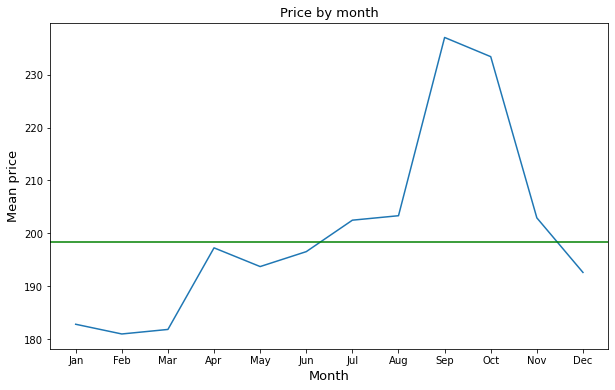

In [215]:
# average price per night
avg_price = calendar.price.mean()
print("Overall average price is of all listings per night {}".format(avg_price))

# converting to category to be able to set the order
monthz['month_name'] = monthz.month_name.astype('category')
ordering = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

monthz.month_name.cat.set_categories(ordering, inplace = True)

plt.figure(figsize = (10, 6))
sns.lineplot(x='month_name', y = 'price', data = monthz)
plt.title('Price by month', fontsize = 13)
plt.xlabel('Month', fontsize = 13)
plt.axhline(avg_price, c = 'g')
plt.ylabel('Mean price', fontsize = 13)


The above plot represents the trend of the average price of room listings for the year 2017. The parts of the graph where the green line is above the blue line the off peak months. i.e. months where the average price of a room per night was less than the overall average for the year. These period ranging from Jan - mid June and Dec.

Areas where the blue line exceed the green line show peak months. E.g the timeframe mid June - mid November represent the busier months as the average prices of rooms during these months exceeded the overall average for the year.

In [216]:
# drop monthz
del(monthz)

#### Question 2 - Who are the hosts with the most number of listings?
Our analysis will only cover the top 30 hosts with the most number of listings.

In [217]:
# lets derive the counts and average pricer per host
counts_and_price = listings.groupby(['host_id','host_name']).agg({'host_id':'count', 'price':'mean'})\
                  .rename(columns = {'host_id':'count_listings','price':'avg_price'})\
                  .sort_values(by = 'count_listings', ascending = False)

In [218]:
# add in cumulative sum and percent
counts_and_price['cum_sum'] = counts_and_price.count_listings.cumsum()
counts_and_price['cum_perc'] = counts_and_price.cum_sum.div(counts_and_price.count_listings.sum()).mul(100)

# inspect top 5
counts_and_price.head()

,,count_listings,avg_price,cum_sum,cum_perc
host_id,host_name,,,,
30283594,Kara,136,236.794118,136,3.793584
25188,Seamless,79,303.050633,215,5.997211
9419684,Mike,61,318.163934,276,7.698745
12243051,Flatbook,58,218.120690,334,9.316597
22348222,Alicia,50,152.500000,384,10.711297


count of listins: 3585


Text(0, 0.5, 'Host name')

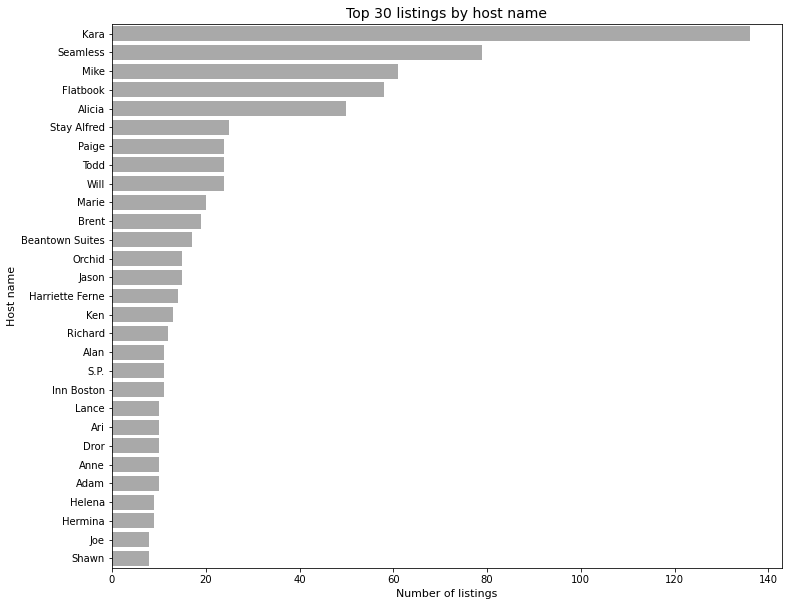

In [219]:
print('count of listins: {}'.format(listings.shape[0]))

# bar plot showing top ten hosts by listings
temp = counts_and_price.reset_index().head(30)

plt.figure(figsize = (12,10))
sns.barplot(data = temp, y = 'host_name', x = 'count_listings', color= 'darkgray')
plt.title('Top 30 listings by host name', fontsize = 14)
plt.xlabel('Number of listings', fontsize = 11)
plt.ylabel('Host name', fontsize = 11)

As displayed in the chart above, the top 5 listings come from Kara, Seamless, Mike, Flatbook and Alicia. These five host together account for about 10 precent of total listings.

#### 3. Which are the most popular neighbourhoods based on average number of reviews?

In [220]:
temp.head()

,host_id,host_name,count_listings,avg_price,cum_sum,cum_perc
0,30283594,Kara,136,236.794118,136,3.793584
1,25188,Seamless,79,303.050633,215,5.997211
2,9419684,Mike,61,318.163934,276,7.698745
3,12243051,Flatbook,58,218.120690,334,9.316597
4,22348222,Alicia,50,152.500000,384,10.711297


In [221]:
temp = listings.groupby('neighbourhood_cleansed').agg({'number_of_reviews':'mean','price':'mean'})\
      .sort_values(by = 'number_of_reviews', ascending = False)\
      .rename(columns = {'price':'avg_price'})

# derive the cumulative sum and percentages for reviews
temp['cum_sum'] = temp.number_of_reviews.cumsum()
temp['cum_per'] = temp.cum_sum.div(temp.number_of_reviews.sum()).mul(100)

# inspect top 5
temp.head(6)

,number_of_reviews,avg_price,cum_sum,cum_per
neighbourhood_cleansed,,,,
Dorchester,27.494424,91.639405,27.494424,16.653533
Jamaica Plain,26.399417,138.478134,53.893841,32.643814
Beacon Hill,21.123711,224.443299,75.017552,45.438569
other,20.314972,178.927966,95.332524,57.743466
South End,17.527607,204.349693,112.860131,68.360040
Brighton,16.497297,118.767568,129.357428,78.352550


Text(0, 0.5, 'neighbourhood')

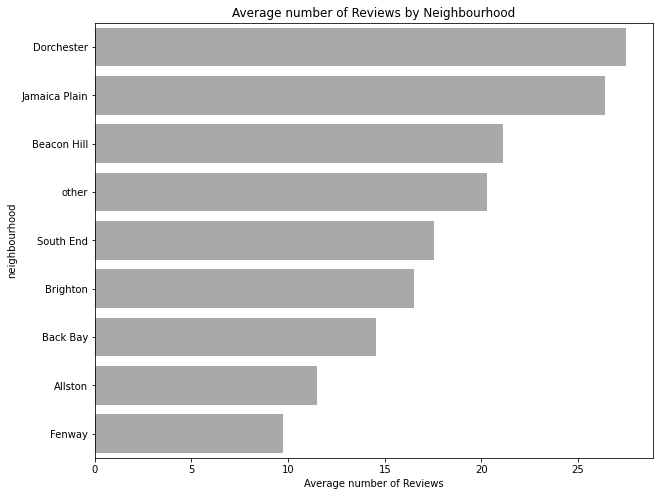

In [260]:
# plot
plt.figure(figsize = (10,8))
sns.barplot(data = temp, y = temp.index, x = 'number_of_reviews', color = 'darkgrey');
plt.title('Average number of Reviews by Neighbourhood')
plt.xlabel('Average number of Reviews')
plt.ylabel('neighbourhood')

The top 5 popular neighbourhoods by number of reviews are Dorchester, Jamaica Plain, Beacon Hill, South End and Brighton which together account for about 66% of average number of reviews.

#### 4.Which neighbourhoods are considered the most expensive in Boston?

In [223]:
temp_price = temp.loc[:,['avg_price']]

# sort by average price
temp_price.sort_values('avg_price', ascending = False, inplace = True)

# compute the cumulative sum and percentages for price
temp_price['cum_price'] = temp_price.avg_price.cumsum()
temp_price['cum_perc_price'] = temp_price.cum_price.div(temp_price.cum_price.sum()).mul(100)

# inspect top 5
temp_price.head()

,avg_price,cum_price,cum_perc_price
neighbourhood_cleansed,,,
Back Bay,240.950331,240.950331,2.721354
Beacon Hill,224.443299,465.393630,5.256274
Fenway,220.393103,685.786734,7.745450
South End,204.349693,890.136427,10.053428
other,178.927966,1069.064393,12.074286


Text(0, 0.5, 'average price')

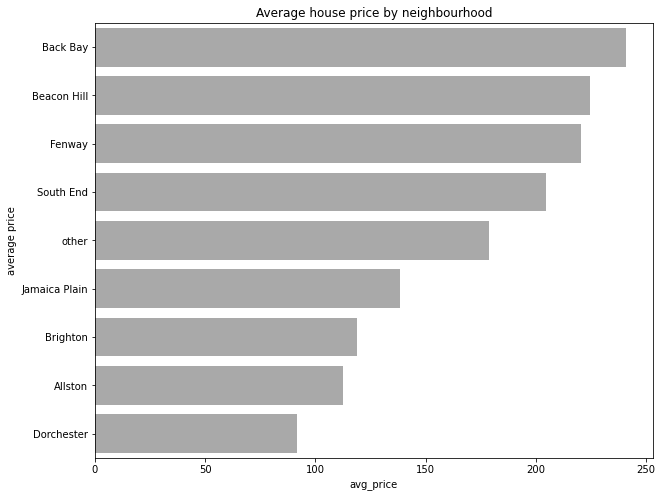

In [261]:
# generate bar plots
plt.figure(figsize = (10, 8))
sns.barplot(data = temp_price, x = 'avg_price', y = temp_price.index, color = 'darkgrey');
plt.title('Average house price by neighbourhood')
plt.ylabel('average price')

The bar chart shows that Back Bay tops the list of most expensive listings with an average house price per night of $240.95, followed by Beacon Hill with an average per night house price of $224.4


### 5. Modelling the key drivers of AirBnB listings


In [225]:
# First we'll drop out the columns we dont need
listings.drop(labels = ['host_id','host_name'], axis = 1, inplace = True)

#### 5.1 Data Preparation
we'll fill values of numerical fields with the median since this goal of this project is to identify factors that influence prices of airBnB, we'll treat proprocess before applying kfold cross validation

In [226]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 45 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_response_time                3114 non-null   float64
 1   host_response_rate                3114 non-null   float64
 2   host_acceptance_rate              3114 non-null   float64
 3   host_has_profile_pic              3585 non-null   int64  
 4   host_identity_verified            3585 non-null   int64  
 5   neighbourhood_cleansed            3585 non-null   object 
 6   is_location_exact                 3585 non-null   int64  
 7   property_type                     3585 non-null   object 
 8   room_type                         3585 non-null   object 
 9   accommodates                      3585 non-null   int64  
 10  bathrooms                         3571 non-null   float64
 11  bedrooms                          3575 non-null   float64
 12  beds  

In [227]:
listings.describe()

,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,description_count,access_count,amenities_count,house_rules_count,host_about_count,host_verifications_count,customer_tenure,day_since_last_rev
count,3114.000000,3114.000000,3114.000000,3585.000000,3585.000000,3585.000000,3585.000000,3571.000000,3575.000000,3576.000000,3585.000000,1342.000000,2478.000000,3585.000000,3585.000000,3.585000e+03,3585.00000,3585.000000,3585.000000,3585.000000,3585.000000,2772.000000,2762.000000,2765.000000,2767.000000,2763.000000,2764.000000,3585.000000,3585.000000,3585.000000,3585.000000,3585.000000,2829.000000,3585.000000,2096.000000,3585.000000,2393.000000,2276.000000,3585.000000,3585.000000,2829.000000
mean,3.266217,0.949891,0.841731,0.997768,0.726081,0.859135,3.041283,1.221647,1.255944,1.609060,173.925802,324.698212,68.380145,1.429847,10.886192,2.872584e+04,8.64993,21.833194,38.558159,179.346444,19.044630,91.916667,9.431571,9.646293,9.646549,9.414043,9.168234,0.165690,2.210042,0.018689,0.066109,12.733891,1.970908,132.304324,35.607824,12.287866,53.675721,80.597100,3.978243,3.766215,567.516437
std,0.761317,0.125177,0.217793,0.047193,0.446030,0.347930,1.778929,0.501487,0.753060,1.011745,148.331321,328.873075,51.297835,1.056787,19.137773,1.670136e+06,10.43533,21.860966,33.158272,142.136180,35.571658,9.531686,0.931863,0.762753,0.735507,0.903436,1.011116,0.371854,0.877998,0.135443,0.248507,29.415076,2.120561,56.676412,38.949668,4.608468,56.806073,81.207539,0.932173,1.700776,164.998723
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,10.000000,95.000000,5.000000,0.000000,0.000000,1.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,4.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.317808,481.000000
25%,3.000000,0.970000,0.710000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,85.000000,100.000000,25.000000,1.000000,0.000000,3.650000e+02,0.00000,0.000000,0.000000,19.000000,1.000000,89.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.480000,80.000000,12.000000,9.000000,13.000000,28.000000,4.000000,2.528767,490.000000
50%,3.000000,1.000000,0.940000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,150.000000,250.000000,50.000000,1.000000,0.000000,1.125000e+03,4.00000,16.000000,37.000000,179.000000,5.000000,94.000000,10.000000,10.000000,10.000000,10.000000,9.000000,0.000000,2.000000,0.000000,0.000000,2.000000,1.170000,161.000000,22.000000,12.000000,32.000000,58.000000,4.000000,3.410959,505.000000
75%,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,2.000000,220.000000,450.000000,100.000000,1.000000,20.000000,1.125000e+03,15.00000,40.000000,68.000000,325.000000,21.000000,98.250000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,3.000000,0.000000,0.000000,6.000000,2.720000,175.000000,42.000000,15.000000,71.000000,108.250000,4.000000,4.684932,561.000000
max,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,6.000000,5.000000,16.000000,4000.000000,4500.000000,300.000000,14.000000,200.000000,1.000000e+08,30.00000,60.000000,90.000000,365.000000,404.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,4.000000,1.000000,1.000000,136.000000,19.150000,210.000000,211.000000,33.000000,205.000000,684.000000,

##### Missing Value imputation

In [228]:
listings.isnull().mean().sort_values(ascending = False)

security_deposit                    0.625662
access_count                        0.415342
host_about_count                    0.365132
house_rules_count                   0.332497
cleaning_fee                        0.308787
review_scores_accuracy              0.229568
review_scores_location              0.229289
review_scores_value                 0.229010
review_scores_checkin               0.228731
review_scores_communication         0.228173
review_scores_rating                0.226778
day_since_last_rev                  0.210879
reviews_per_month                   0.210879
host_response_rate                  0.131381
host_acceptance_rate                0.131381
host_response_time                  0.131381
bathrooms                           0.003905
bedrooms                            0.002789
beds                                0.002510
instant_bookable                    0.000000
bed_type                            0.000000
host_verifications_count            0.000000
amenities_

In [229]:
# Numeric fields - fill blanks with median 
# create a list of numeric fields and assign to an object
numeric_fields = [col for col in listings.columns if listings[col].dtype != 'object' and col != 'price']

for col in numeric_fields:
    listings[col].fillna(listings[col].median(), inplace = True)

#### Correlation analysis

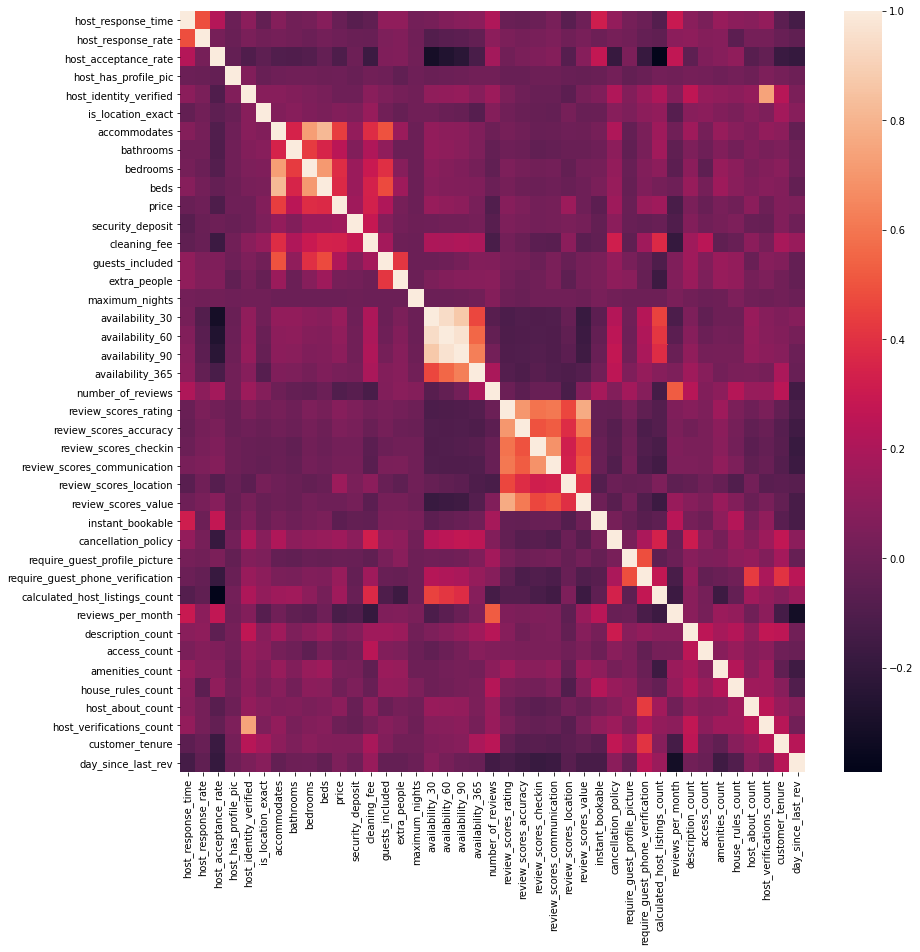

In [230]:
plt.figure(figsize = (14, 14))
sns.heatmap(listings.corr(), annot = False);

In [231]:
corrmat = listings.corr()
corrmat.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_has_profile_pic,host_identity_verified,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,description_count,access_count,amenities_count,house_rules_count,host_about_count,host_verifications_count,customer_tenure,day_since_last_rev
host_response_time,1.000000,0.486485,0.226954,-0.009507,0.093657,-0.036131,0.071224,0.014003,0.027705,0.078862,-0.019908,-0.072795,-0.044653,0.112466,0.113245,0.017954,0.031859,0.064035,0.082149,0.097958,0.210734,-0.014611,-0.024242,-0.008441,0.037163,-0.066997,0.001083,0.316460,0.123913,0.027383,-0.005972,-0.081398,0.298868,0.091395,0.040585,0.136068,0.093556,0.086779,0.125149,-0.057350,-0.135398
host_response_rate,0.486485,1.000000,0.027993,-0.012448,0.039946,0.014010,0.026307,0.013003,-0.009075,0.018307,0.001229,-0.013052,-0.020496,0.051498,0.062635,0.006169,-0.088114,-0.068709,-0.056748,-0.033927,0.099759,0.047588,0.022928,0.036021,0.050239,0.006731,0.038269,-0.004364,0.032389,0.015836,-0.027853,-0.044637,0.096614,0.106454,0.072357,0.078220,-0.054363,0.024826,0.025937,-0.019672,-0.047937
host_acceptance_rate,0.226954,0.027993,1.000000,-0.028253,-0.097759,-0.051452,-0.096259,-0.097535,-0.084406,-0.027428,-0.105804,-0.004810,-0.169528,0.054913,0.064757,0.011795,-0.309741,-0.269700,-0.236624,-0.123138,0.170542,0.016598,0.042598,0.055301,0.072683,-0.078123,0.081024,0.273442,-0.184771,0.045663,-0.187462,-0.390477,0.267700,-0.051563,0.054915,0.079730,0.112820,-0.070520,-0.035201,-0.176474,-0.193774
host_has_profile_pic,-0.009507,-0.012448,-0.028253,1.000000,0.063740,-0.019149,0.001098,0.009048,0.008190,-0.000817,0.000893,-0.017972,0.013819,0.002455,-0.042605,0.000791,-0.012351,-0.009827,0.000083,0.013384,0.014686,-0.016760,-0.017370,-0.001572,-0.001627,-0.018601,-0.026304,-0.010724,0.018049,-0.037125,-0.011209,0.018868,0.008090,0.027063,0.017751,0.004237,0.021618,0.000340,0.049636,0.022489,-0.002000
host_identity_verified,0.093657,0.039946,-0.097759,0.063740,1.000000,0.085709,0.084937,0.067850,0.052927,0.036877,0.002059,0.003780,0.089955,0.050380,0.026779,0.010257,0.110615,0.118416,0.129912,0.079859,0.150444,0.046853,0.003632,-0.016314,-0.015940,-0.057605,0.032572,0.055024,0.213218,0.070908,0.138245,0.202940,0.067623,0.262798,0.128508,0.110993,0.093339,0.120928,0.740622,0.236826,0.048878


In [232]:
# variables showing strongest correlation with price
corrmat.loc['price'].sort_values(ascending = False)[:15]

price                               1.000000
accommodates                        0.437756
bedrooms                            0.384895
beds                                0.370671
cleaning_fee                        0.334067
bathrooms                           0.248554
guests_included                     0.211806
calculated_host_listings_count      0.161855
security_deposit                    0.160151
cancellation_policy                 0.156701
review_scores_location              0.150576
require_guest_phone_verification    0.134929
availability_30                     0.132100
availability_60                     0.112577
availability_90                     0.098526
Name: price, dtype: float64

In [233]:
for col in corrmat:
    for row in corrmat:
        if corrmat.loc[row, col] > 0.7 and row != col:
            print("{0} {1}: {2}".format(row, col, corrmat.loc[row,col]))

host_verifications_count host_identity_verified: 0.7406218460696843
bedrooms accommodates: 0.7249176208821587
beds accommodates: 0.8154799500298812
accommodates bedrooms: 0.7249176208821587
beds bedrooms: 0.710838569740628
accommodates beds: 0.8154799500298812
bedrooms beds: 0.710838569740628
availability_60 availability_30: 0.9417061387540392
availability_90 availability_30: 0.8701670862451212
availability_30 availability_60: 0.9417061387540392
availability_90 availability_60: 0.9647305166423469
availability_30 availability_90: 0.8701670862451212
availability_60 availability_90: 0.9647305166423469
review_scores_accuracy review_scores_rating: 0.7016953990320572
review_scores_value review_scores_rating: 0.7686570199646474
review_scores_rating review_scores_accuracy: 0.7016953990320572
review_scores_rating review_scores_value: 0.7686570199646474
host_identity_verified host_verifications_count: 0.7406218460696843


##### Interesting findings:
1. In descending order, the variables with the strongest correlations to price are: accomodates, bedrooms, beds, cleaning_fee,cancellation_policy, review_scores_location, calculated_host_listings_count
2. The correlation between the pairs or the availability fields is close to 1. To reduce dimensionality, we can pick one. Similar correlations exist for the pairs of variables above.

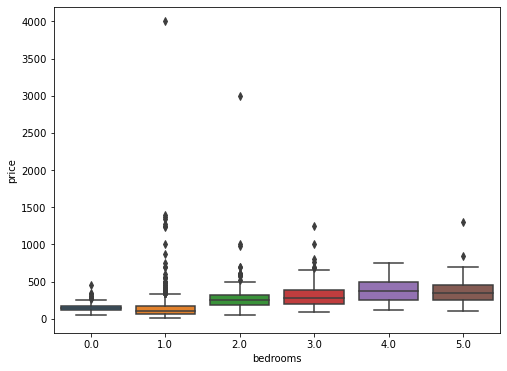

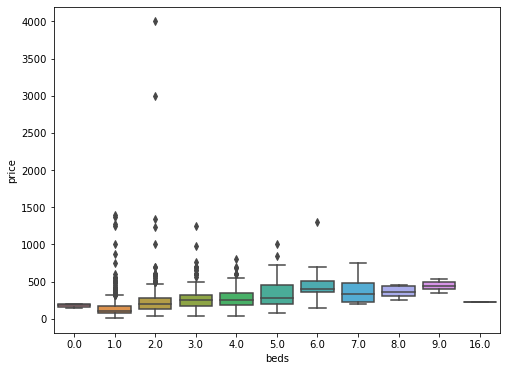

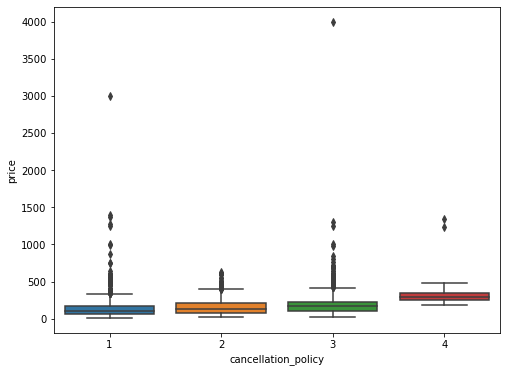

In [234]:
# lets take a closer look at the relationships of point 1 variables with price and also the distributions
for col in ['bedrooms','beds','cancellation_policy']:
    plt.figure(figsize = (8,6))
    sns.boxplot(data = listings, x = col, y = 'price');
    plt.show()

In [235]:
drop_list = ['host_identity_verified','bedrooms','beds','availability_60','availability_90',
             'review_scores_accuracy','review_scores_rating','host_verifications_count']

listings.drop(columns = drop_list, inplace = True)

#### Extreme Value analysis

(0.0, 1000.0)

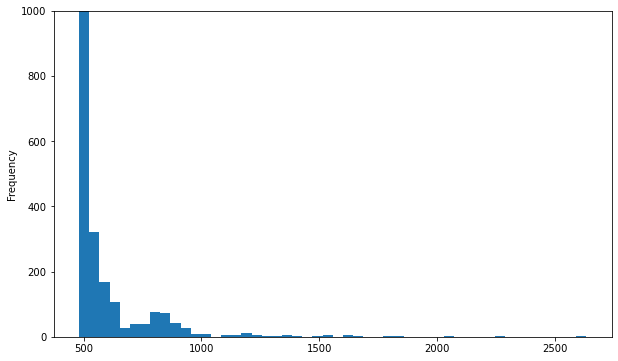

In [236]:
listings.day_since_last_rev.plot(kind = 'hist', bins = 50, figsize = (10, 6));
plt.ylim((0,1000))

In [237]:
# apply top coding to trim outliers
numeric_fields = [col for col in listings.columns if listings[col].dtype != 'object'] + ['price']

for col in numeric_fields:
    top_bottom_coding(col)

#### categorical variable encodings

In [239]:
# create a list of object fields
obj_fields = [col for col in listings.columns if listings[col].dtype == 'object'] 
obj_fields

['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']

#### Variable selection

In [240]:
corrmat = np.abs(listings.corr())
print('Number of Variables with cor > 0.1: {}'.format(np.sum(corrmat.loc['price'] > 0.1)))

corr_features = []
for i,x in (corrmat.loc['price'] > 0.1).items():
    if x:
        corr_features.append(i)   
        
desired_fields = corr_features + obj_fields 
print(desired_fields)

Number of Variables with cor > 0.1: 12
['host_acceptance_rate', 'accommodates', 'price', 'cleaning_fee', 'availability_30', 'number_of_reviews', 'review_scores_location', 'cancellation_policy', 'calculated_host_listings_count', 'reviews_per_month', 'host_about_count', 'customer_tenure', 'neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']


In [241]:
listings2 = listings.loc[:,desired_fields]

In [242]:
# label encode all categorical fields
#for col in obj_fields:
#    label_encode(col)

##### Alternatively - one hot encode the character fields

In [243]:
print('Shape: {}'.format(listings2.shape))
listings2 = pd.get_dummies(data = listings2, columns = obj_fields, drop_first = True)

print("New Shape: {}".format(listings2.shape))

Shape: (3585, 16)
New Shape: (3585, 29)


In [244]:
# assign the target
y = listings2.pop('price')

# assign the inputs
X = listings2

#### Modelling with K fold cross validation
Due to the relatively high dimensionality of our data, we'll find a way to reduce the complexity. A number of approaches are used including Ridge Regression and Lasso which are both shrinkage methods

Kfold cross validation will be used to validate the model. The key advantage of this approach is that it ensures the whole dataset is used for training and also for validation, thus giving us a more realistic picture of model performance while ensuring variance is minimised. Worth noting that the spliting will be done without replacing, that way each sample can only be used for training and validation once

#### Ridge Regression
Due to the correlation between the features in our model, Ridge regression is a good candidate for dealing with multicollinearity. By adding a degree of bias to the regression coefficients, ridge regression reduces the standard errors. The final goal of applying this is to give estimates that are more reliable. Using the alpha value, we can impose a maximum value on the sum of all our weights, thereby decreasing unimportant parameters. Choosing a suitable alpha is the challenge here

In [249]:
alphas = 10**np.linspace(-3,3,100)

X_shuffle, y_shuffle = shuffle(X, y, random_state = 32)

ridge_cv = RidgeCV(alphas = alphas, normalize = True, cv = 10, scoring = 'neg_mean_squared_error')
ridge_cv.fit(X_shuffle, y_shuffle)

#best alpha
ridge_cv.alpha_

0.012328467394420659

In [250]:
# create an instance of the model
ridge = Ridge(alpha = ridge_cv.alpha_)

# fit model
ridge.fit(X_shuffle, y_shuffle)

# predict
preds = ridge.predict(X_shuffle)

# measure model performance
mse = mean_squared_error(y_shuffle, preds)
print('RMSE: {}'.format(np.sqrt(mse)))

RMSE: 76.69143413131462


In [256]:
# examine the coefficients
coef_df = pd.DataFrame()
coef_df['col'] = X_shuffle.columns
coef_df['coefs'] = ridge.coef_
coef_df['abs_coef'] = np.abs(ridge.coef_)
coef_df = coef_df.sort_values('abs_coef', ascending = False)

coef_df

,col,coefs,abs_coef
11,neighbourhood_cleansed_Back Bay,66.705884,66.705884
12,neighbourhood_cleansed_Beacon Hill,66.135679,66.135679
23,room_type_Shared room,-58.896777,58.896777
17,neighbourhood_cleansed_South End,49.671013,49.671013
15,neighbourhood_cleansed_Fenway,49.449013,49.449013
22,room_type_Private room,-48.917058,48.917058
25,bed_type_Futon,-39.611441,39.611441
26,bed_type_Pull-out Sofa,-37.855155,37.855155
18,neighbourhood_cleansed_other,26.686923,26.686923
1,accommodates,25.089980,25.089980


Neighbourhood appears to be one of the key determinants of airBnB listings, followed by room type. Bed type, accomodates and property type follow.